# Examples of utils provided by ReGraph's neo4j module

In [1]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

## Initializing Neo4j graph

0. When installing neo4j you will be asked to choose login/password for you dbs (here its "neo4j"/"admin"), if you choose other -- change in the cell below.
1. To start neo4j server run `sudo service neo4j start`
2. Check status by running `sudo service neo4j status`. Here you can check the _bolt_ port, change the cell below if different from 7687
3. You can query the db by using the neo4j browser, the address can be found also in the result of 'status', e.g. "Remote interface available at http://localhost:7474/".

In [2]:
# initialize the neo4j driver, wrappped into Neo4jGraph object
g = Neo4jGraph(uri="bolt://localhost:7687", user="neo4j", password="admin")

In [3]:
# here we clear the db
res = g.clear()

In [4]:
nodes = [
    ("a", {"name": "Jack", "age": 23, "hobby": {"hiking", "music"}, "weight": 75}), 
    ("b", {"name": "Bob", "age": 24, "hobby": {"sport", "music"}, "height": 178}),
    "c", 
    ("d", {"name": "Paul"}), "e", "f"
]
edges = [
    ("a", "b", {"type": {"friends", "colleagues"}}), 
    ("d", "b", {"type": "enemies"}), 
    ("a", "c"),
    ("d", "a", {"type": "friends"}),
    ("e", "a"), 
    ("f", "d")
]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

In [5]:
print(get_node("a"))
print(g.get_node("a"))

MATCH (n { id : 'a' })
RETURN n

{'name': ['Jack'], 'age': [23], 'id': 'a', 'weight': [75], 'hobby': ['music', 'hiking']}


## Primitive operations on Neo4j graph

### Basic operations

In [6]:
g.add_node("x", {"name": "Roberto"})

In [7]:
g.add_edge("x", "c", {"type": {"friends", "colleagues"}, "since": 1993})

In [8]:
g.nodes()

['a', 'b', 'c', 'd', 'e', 'f', 'x']

In [9]:
g.edges()

[('a', 'c'),
 ('a', 'b'),
 ('d', 'a'),
 ('d', 'b'),
 ('e', 'a'),
 ('f', 'd'),
 ('x', 'c')]

In [10]:
g.get_edge('a', 'b')

{'type': ['friends', 'colleagues']}

### Cloning

By default if we clone a node without specifying the new id for it, the id is automatically derived from the original one (however it takes some additional time to generate it, and some naming collisions may happen in the future when using clone operation inside of complex queries)

In [11]:
clone1_res = g.clone_node('a')
print("Created clone by the name: ", clone1_res)
print("Properties of the resulting node: ")
print(g.get_node(clone1_res))
print("Properties of incident edges are also cloned, e.g: ")
print(g.get_edge(clone1_res, 'b'))

Created clone by the name:  a1
Properties of the resulting node: 
{'name': ['Jack'], 'age': [23], 'id': 'a1', 'weight': [75], 'hobby': ['music', 'hiking']}
Properties of incident edges are also cloned, e.g: 
{'type': ['friends', 'colleagues']}


We can specify the parameter `ignore_naming=True` to avoid automatic id derivation. In this case cloning uses Neo4j native ids (this mode is more suitable for using clone operation inside of complex queries as the Neo4j id have the guaranteed uniqueness)

In [12]:
print("Here we ignore pretty naming of new clones\n")
clone2_res = g.clone_node('a', ignore_naming=True)
print("Created clone by the name: ", clone2_res)
print("Properties of the resulting node: ")
print(g.get_node(clone2_res))
print("Properties of incident edges are also cloned, e.g: ")
print(g.get_edge(clone2_res, 'b'))

Here we ignore pretty naming of new clones

Created clone by the name:  575
Properties of the resulting node: 
{'name': ['Jack'], 'age': [23], 'id': '575', 'weight': [75], 'hobby': ['music', 'hiking']}
Properties of incident edges are also cloned, e.g: 
{'type': ['friends', 'colleagues']}


The third option is to specify the id of the new node manually

In [13]:
clone3_res = g.clone_node('a', 'a_clone')
print("Created clone by the name: ", clone3_res)
print("Properties of the resulting node: ")
print(g.get_node(clone3_res))
print("Properties of incident edges are also cloned, e.g: ")
print(g.get_edge(clone3_res, 'b'))

Created clone by the name:  a_clone
Properties of the resulting node: 
{'name': ['Jack'], 'age': [23], 'id': 'a_clone', 'weight': [75], 'hobby': ['music', 'hiking']}
Properties of incident edges are also cloned, e.g: 
{'type': ['friends', 'colleagues']}


In [14]:
merge1_res = g.merge_nodes1(["a", "b"])
print("Properties of the resulting node: {}".format(merge1_res))
print(g.get_node(merge1_res))

Properties of the resulting node: a_b
{'hobby': ['music', 'hiking', 'sport'], 'age': [23, 24], 'name': ['Jack', 'Bob'], 'weight': [75], 'id': 'a_b', 'height': [178]}


In [15]:
merge2_res = g.merge_nodes(["a_b", "d"])
print("Properties of the resulting node: {}".format(merge2_res))
print(g.get_node(merge2_res))

Properties of the resulting node: a_b_d
{'hobby': ['music', 'hiking', 'sport'], 'age': [23, 24], 'name': ['Jack', 'Bob', 'Paul'], 'weight': [75], 'id': 'a_b_d', 'height': [178]}


## Rewriting Neo4j graph

### 1. Create an SqPO rewriting rule

In [16]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z"])
pattern.add_edges_from([("y", "x"), ("y", "z"), ("z", "z")])

In [17]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
clone_name2, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name2, "z")
rule.inject_remove_node("x")
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

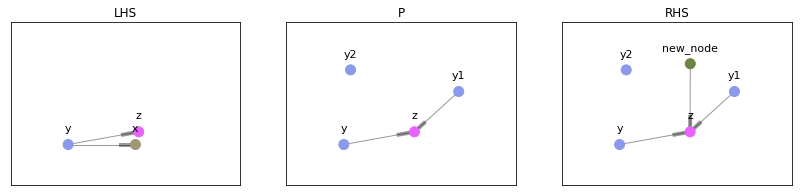

In [18]:
plot_rule(rule)

In [19]:
instances = g.find_matching(pattern)
print("Instances: ", instances)

Instances:  [{'y': '575', 'z': 'a_b_d', 'x': 'c'}, {'y': 'a_clone', 'z': 'a_b_d', 'x': 'c'}, {'y': 'a1', 'z': 'a_b_d', 'x': 'c'}, {'y': 'e', 'z': 'a_b_d', 'x': 'a_clone'}, {'y': 'e', 'z': 'a_b_d', 'x': '575'}, {'y': 'e', 'z': 'a_b_d', 'x': 'a1'}]


In [20]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())

Rewriting rule to Cypher: 

// Match nodes and edges of the instance 
MATCH (lhs_y:node { id : '575'}), (lhs_z:node { id : 'a_b_d'}), (lhs_x:node { id : 'c'}) , (lhs_y)-[lhs_y_lhs_z:edge]->(lhs_z), (lhs_y)-[lhs_y_lhs_x:edge]->(lhs_x), (lhs_z)-[lhs_z_lhs_z:edge]->(lhs_z)

// Cloning node 'y' of the lhs 
// Create clone corresponding to 'y1' of the preserved part
// create a node corresponding to the clone
CREATE (p_y1:node) 
WITH p_y1, toString(id(p_y1)) as p_y1_id, lhs_y.id as original_old, lhs_y_lhs_z, lhs_y, lhs_z, lhs_z_lhs_z, lhs_y_lhs_x, lhs_x 
// set the id property of the original node to NULL
SET lhs_y.id = NULL
// copy all the properties of the original node to the clone
SET p_y1 = lhs_y
// set id property of the clone to neo4j-generated id
SET p_y1.id = toString(id(p_y1)), p_y1.count = NULL
// set back the id property of the original node
SET lhs_y.id = original_old
WITH p_y1, toString(id(p_y1)) as p_y1_id, lhs_y_lhs_z, lhs_y, lhs_z, lhs_z_lhs_z, lhs_y_lhs_x, lhs_x 
WITH [] a

In [21]:
rhs_g

{'new_node': '579', 'y': '575', 'y1': '577', 'y2': '578', 'z': 'a_b_d'}